# Training on 13,231 events from ACTS. Testing on 3308 events from ACTS.

In [1]:
!nvidia-smi

Thu Oct  5 13:41:38 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   31C    P8     9W / 180W |      0MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   32C    P8     9W / 180W |      0MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


### Load in the data.

In [3]:
%%time
modelpath = "data/models/ACTS-T50-EV99615.h5"
filepath  = "data/sets/ACTS-T50-EV99615.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del events

Train is list of 79692 events.
Test is list of 19923 events.
Train takes up 637600 bytes.
Test takes up 159448 bytes.
CPU times: user 32 s, sys: 1.4 s, total: 33.4 s
Wall time: 33.3 s


In [4]:
order = ["phi", "r", "z"]

### Get an idea for how the tracks are distributed among the events.

In [ ]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

In [ ]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

### Show an example of the data.

Train 32497
Number of Hits: 109
Number of Tracks: 33


<IPython.core.display.Javascript object>


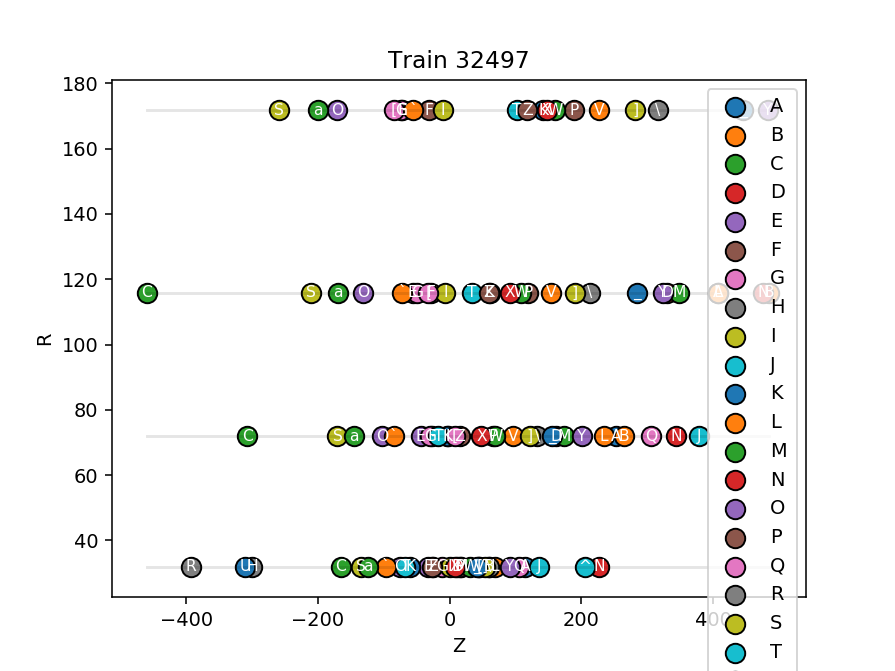

<IPython.core.display.Javascript object>


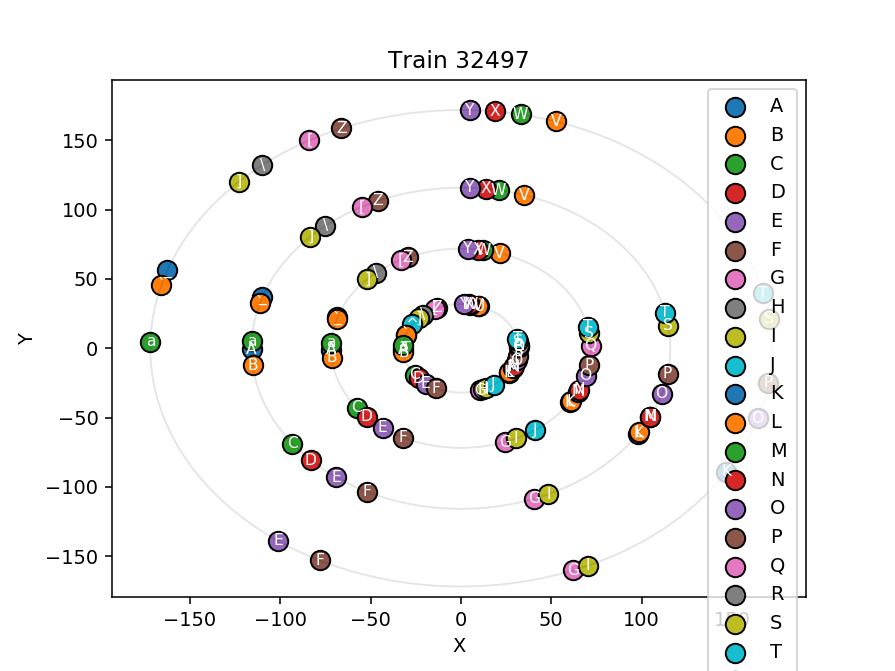

In [5]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="zr", title="Train {}".format(n))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [6]:
visuals.display(train[n], order)

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,[,\,],^,_,`,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,noise,pad
0,-3.134565,115.816565,406.971000,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-3.127534,71.843929,253.122000,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-3.120603,31.959962,114.422000,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-3.051175,31.959962,59.609400,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,-3.044044,71.843929,264.242000,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,-3.036583,115.816565,484.457000,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.506177,115.816565,-460.175000,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.503120,71.843929,-307.199000,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.500193,31.959962,-165.206000,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.392048,31.959962,11.684400,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Create the model.

In [7]:
input_shape  = (200, 3)
n_categories = 50 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [8]:
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [6]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
# model.add(Dropout(rate=1/2))
# model.add(Bidirectional(
#     GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
#     merge_mode="mul"))
# model.add(Dropout(rate=1/2))
# model.add(Bidirectional(
#     GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
#     merge_mode="mul"))
# model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 200, 256)          399360    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 200, 52)           13364     
Total params: 412,724
Trainable params: 412,724
Non-trainable params: 0
_________________________________________________________________


### Fit the model.

In [8]:
%%time
epochs     = 128
batch_size = 50
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=10, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)]))

Epoch 1/128
1593/1593 [==============================] - 821s - loss: 0.5256 - acc: 0.7945 - val_loss: 0.4125 - val_acc: 0.8075
Epoch 2/128
1593/1593 [==============================] - 788s - loss: 0.4398 - acc: 0.8305 - val_loss: 0.2905 - val_acc: 0.9282
Epoch 3/128
1593/1593 [==============================] - 783s - loss: 0.3795 - acc: 0.8584 - val_loss: 0.2494 - val_acc: 0.9296
Epoch 4/128
1593/1593 [==============================] - 769s - loss: 0.3452 - acc: 0.8741 - val_loss: 0.2378 - val_acc: 0.9219
Epoch 5/128
1593/1593 [==============================] - 771s - loss: 0.3236 - acc: 0.8855 - val_loss: 0.2087 - val_acc: 0.9399
Epoch 6/128
1593/1593 [==============================] - 774s - loss: 0.3022 - acc: 0.8959 - val_loss: 0.1827 - val_acc: 0.9557
Epoch 7/128
1593/1593 [==============================] - 770s - loss: 0.2839 - acc: 0.9054 - val_loss: 0.1712 - val_acc: 0.9597
Epoch 8/128
1593/1593 [==============================] - 776s - loss: 0.2711 - acc: 0.9120 - val_loss: 0

### Display information about the model after fitting it.

In [9]:
%%time
test.sort(key=lambda x: x.iloc[0]["event_id"])
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 91.91391504724947%
Percent of tracks assigned correctly: 85.30135557084427%
Percent of events with the correct number of tracks: 96.74747778948954%
CPU times: user 6min 15s, sys: 532 ms, total: 6min 16s
Wall time: 6min 16s


### Display how one of the model's predictions looks.

In [118]:
%matplotlib notebook

Percent of hits assigned correctly: 88.29787234042553%
Percent of tracks assigned correctly: 75.0%


<IPython.core.display.Javascript object>


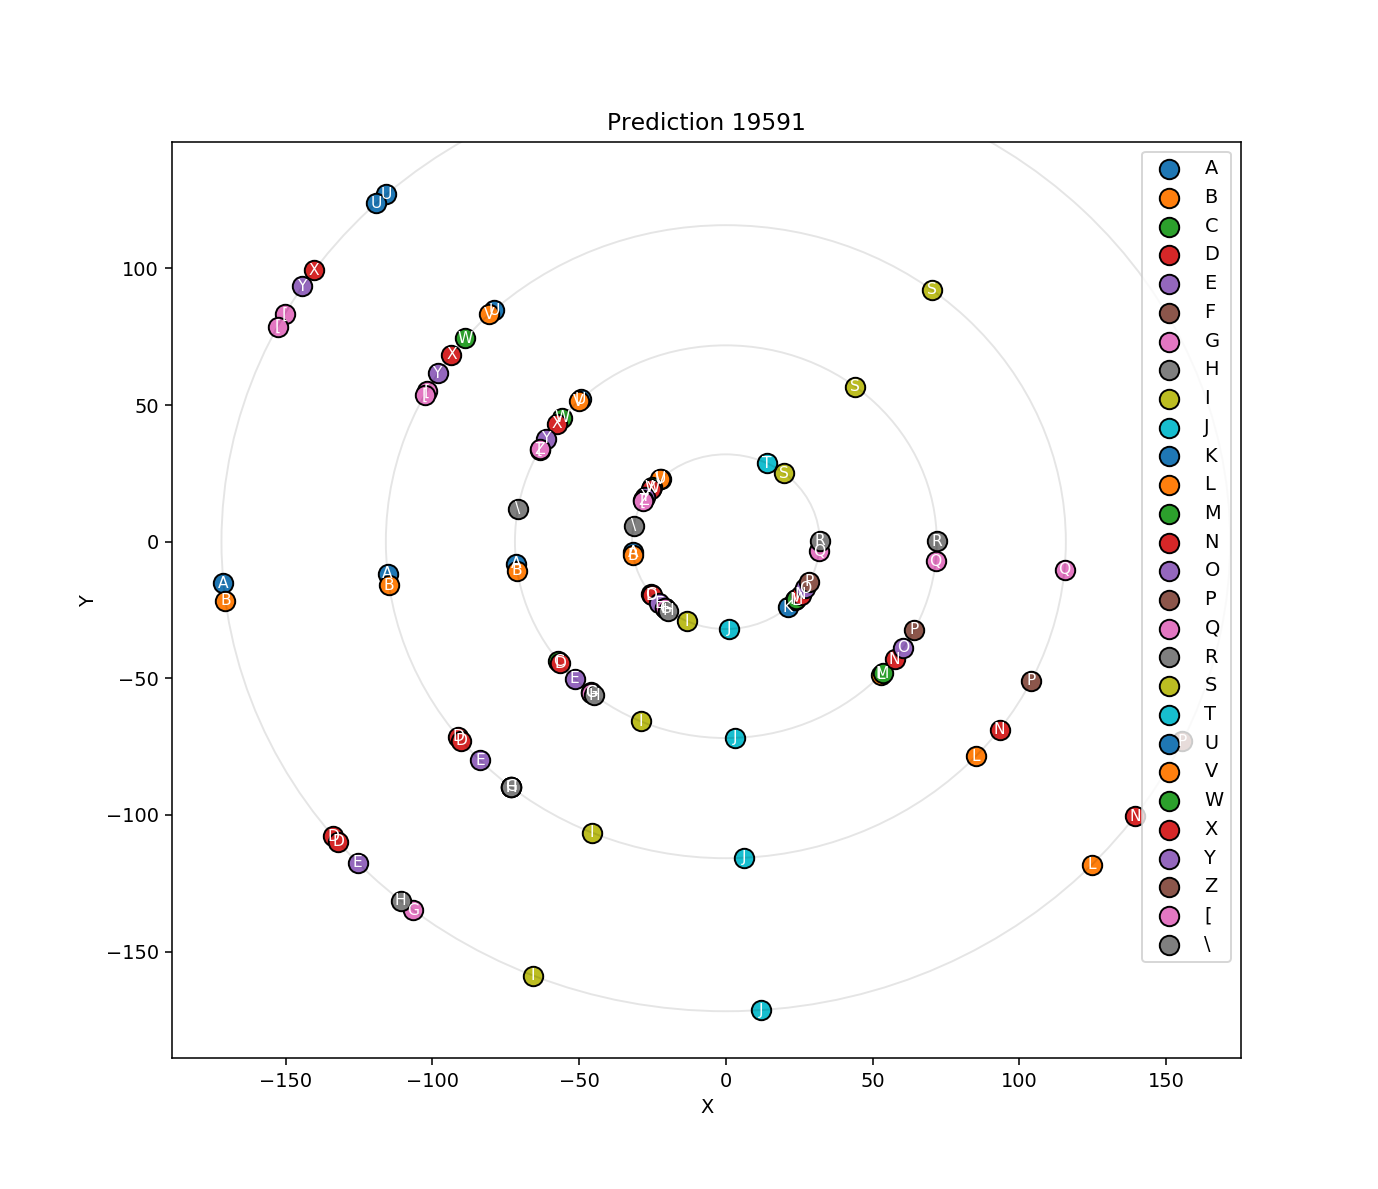

In [119]:
n  = np.random.randint(len(test))
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
#_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr", title="Prediction {}".format(n))
#_ = visuals.Plot2D(test[n], order).plot(mode="zr", title="Answer {}".format(n))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Prediction {}".format(n))
#_ = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer {}".format(n))

In [ ]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

<IPython.core.display.Javascript object>


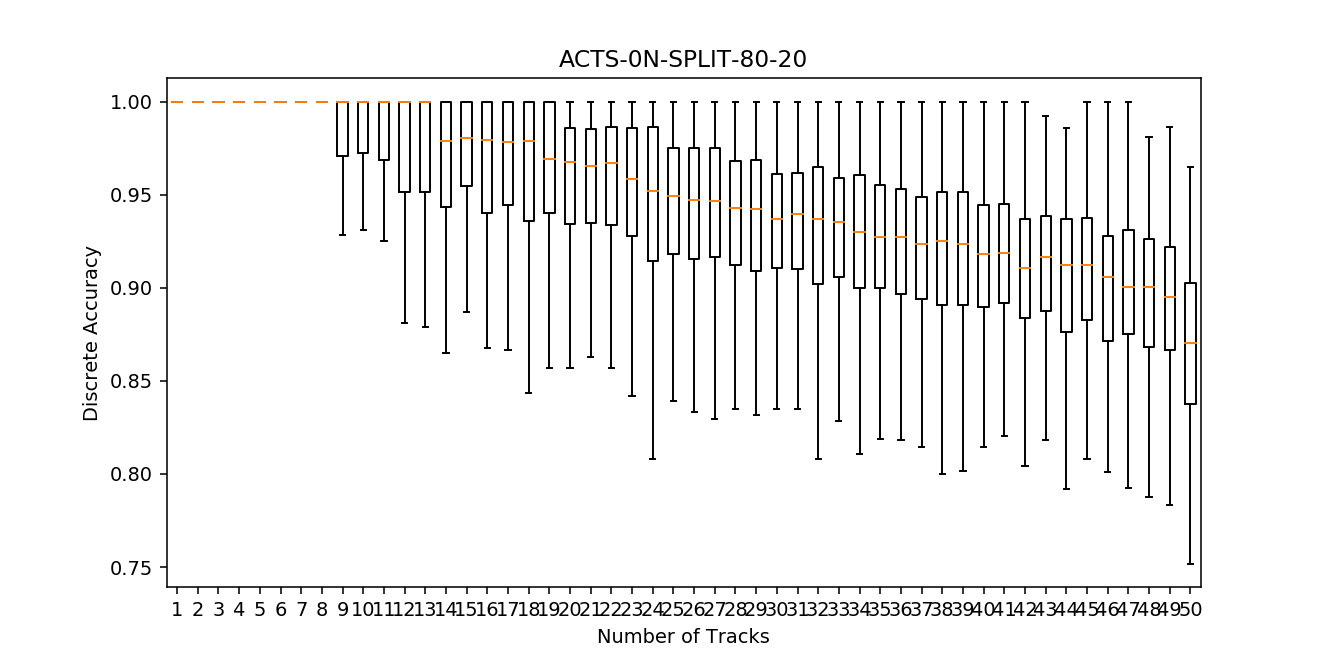

CPU times: user 2min 31s, sys: 32 ms, total: 2min 31s
Wall time: 2min 31s


In [75]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

<IPython.core.display.Javascript object>


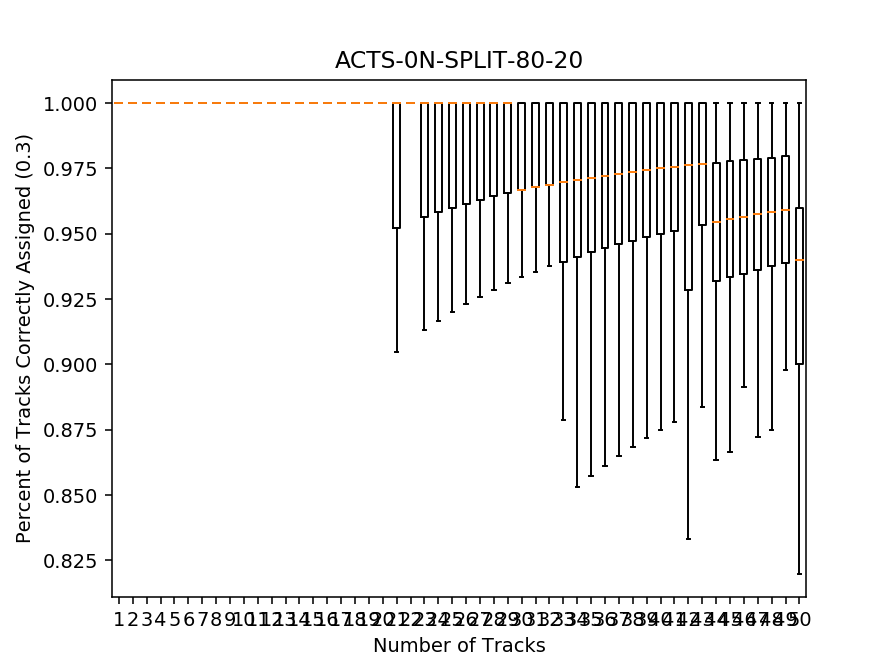

<IPython.core.display.Javascript object>


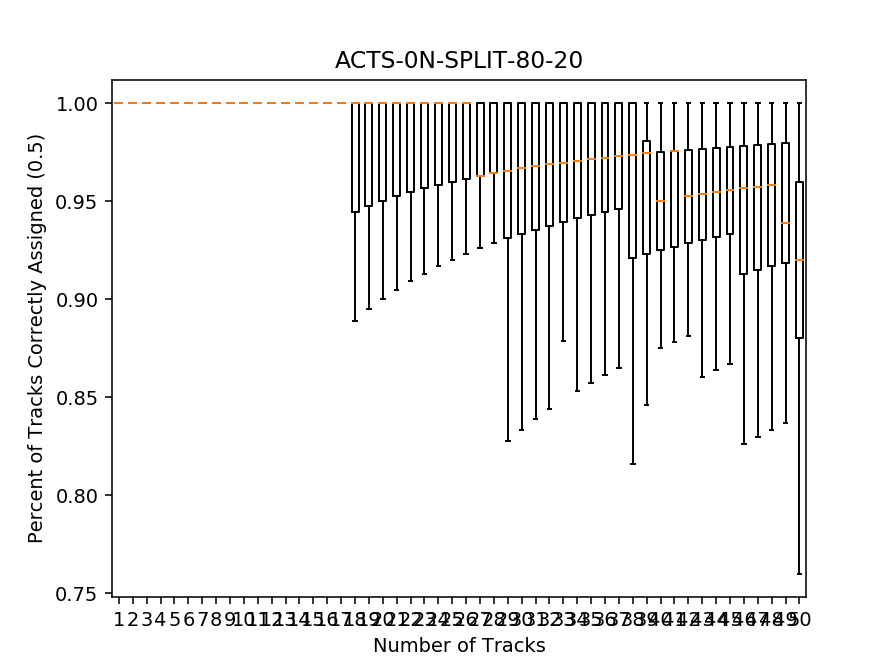

<IPython.core.display.Javascript object>


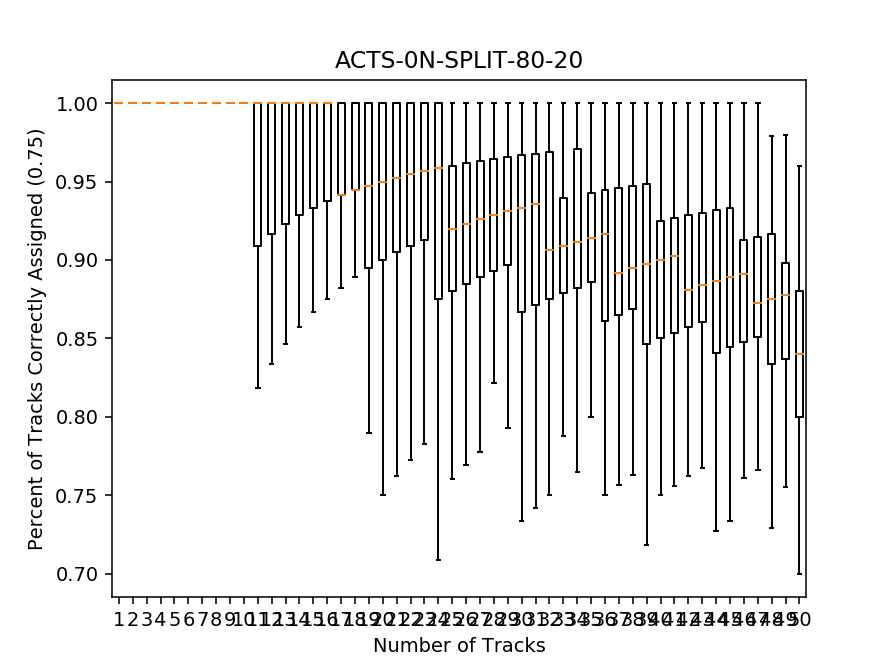

<IPython.core.display.Javascript object>


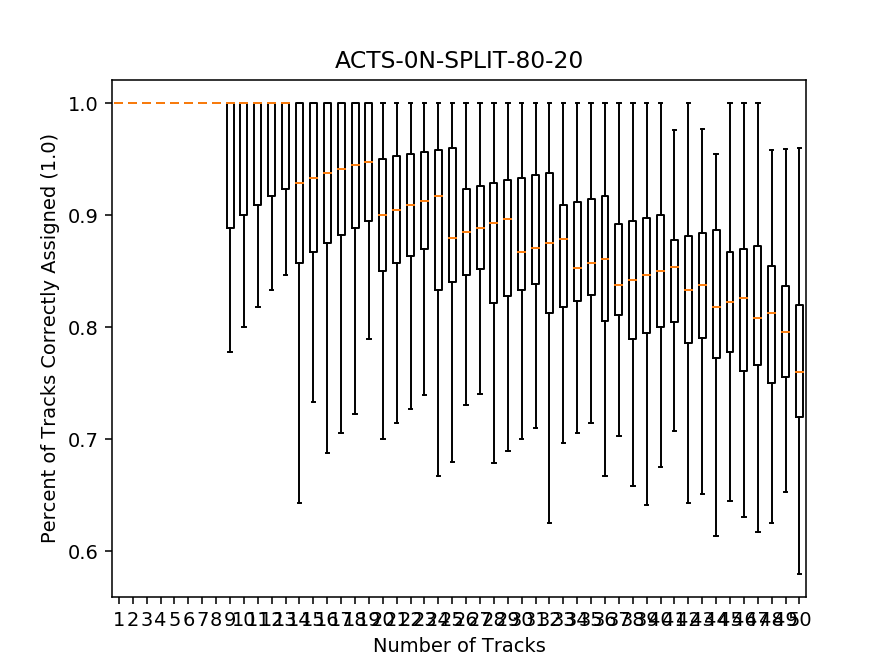

CPU times: user 14min 27s, sys: 328 ms, total: 14min 28s
Wall time: 14min 28s


In [14]:
%%time
for percent in [0.3, 0.5, 0.75, 1.0]:
    c_tracks = [metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order, percent=percent)
                for n in range(len(guesses))]
    boxes = [[] for _ in r]
    for i in range(len(c_tracks)):
        index = metrics.number_of_tracks(test[i]) - 1
        boxes[index].append(c_tracks[i])
    visuals.boxplot(
        boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks",
        "Percent of Tracks Correctly Assigned ({})".format(percent), xticks=list(r))

In [ ]:
%%time
thresholds = [i / 10 for i in range(11)]
threshold_metrics = [[metrics.threshold_metrics(test[i], guesses[i], n, order)
                      for i in range(len(guesses))] for n in thresholds]
boxes_correct   = [[m[0] for m in metric] for metric in threshold_metrics]
boxes_incorrect = [[m[1] for m in metric] for metric in threshold_metrics]
boxes_multi     = [[m[2] for m in metric] for metric in threshold_metrics]
boxes_none      = [[m[3] for m in metric] for metric in threshold_metrics]
visuals.boxplot(
    boxes_correct, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to correct track]", xticks=thresholds)
visuals.boxplot(
    boxes_incorrect, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to an incorrect track]", xticks=thresholds)
visuals.boxplot(
    boxes_multi, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to multiple tracks]", xticks=thresholds)
visuals.boxplot(
    boxes_none, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to no tracks]", xticks=thresholds)

In [ ]:
bad_tracks = []
for i in range(len(test)):
    if ext.extract_output(test[i], order)[0, 0] == 1:
        bad_tracks.append(test[i])
bad_guesses = model.predict(ext.extract_input(bad_tracks, order))
print(metrics.percent_of_hits_assigned_correctly(bad_tracks, bad_guesses, order))

In [45]:
importlib.reload(metrics)

<module 'tracker.metrics' from '/home/jovyan/work/Fermi-Internship-2017/Track/tracker/metrics.py'>

In [52]:
print(min([event["momentum"].min() for event in test]))
print(max([event["momentum"].max() for event in test]))

1.00123
100.446


In [114]:
%%time
momentums = [1 + 1/8, 1 + 1/4, 1 + 1/2, 2, 4, 8, 16, 32, 64, 128]
momentums, momentum_acc = metrics.accuracy_vs_momentum(test, guesses, order, momentums)

CPU times: user 5min 33s, sys: 132 ms, total: 5min 33s
Wall time: 5min 33s


In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [140]:
for acc in momentum_acc:
    print(len([b for b in acc if b == 1]) / len(acc))

0.7885212799005903
0.785740809506127
0.8076422601471398
0.8183606460391647
0.8251556063775874
0.8644231951789447
0.9349888933189041
0.9562347188264059
0.9636135508155583
0.7307692307692307


ZeroDivisionError: division by zero

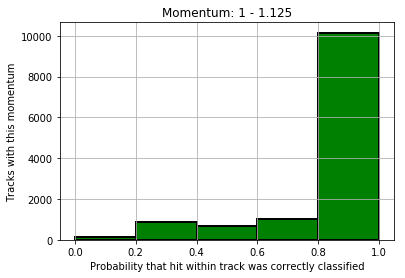

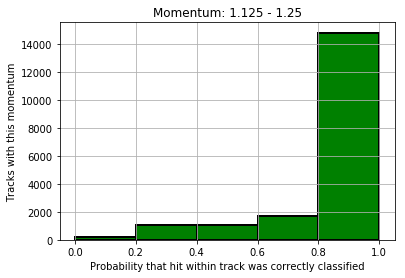

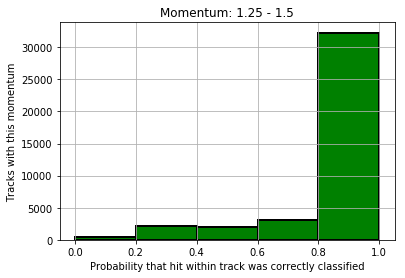

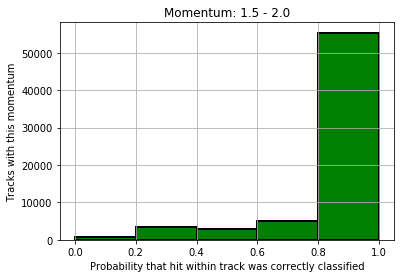

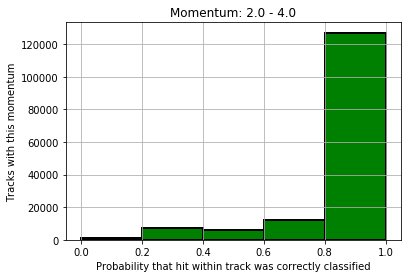

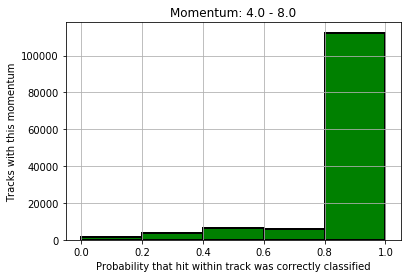

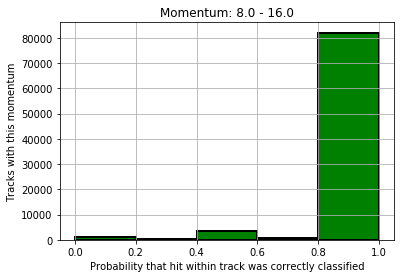

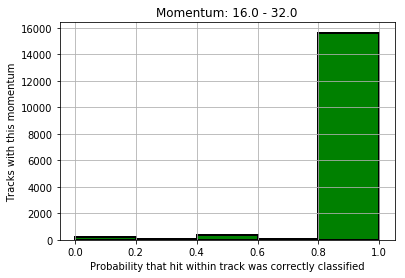

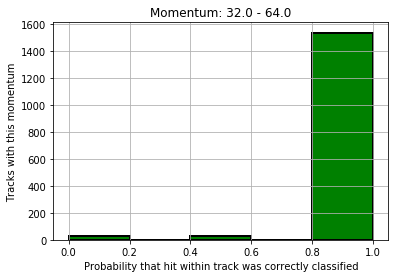

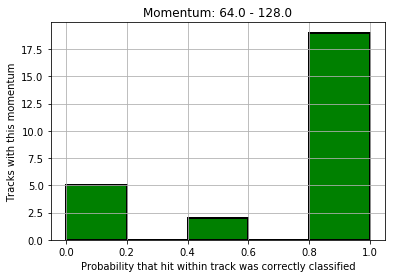

In [134]:
for i, momentum in enumerate(momentums):
    accuracy = momentum_acc[i]
    if accuracy:
        plt.hist(accuracy, bins=5, range=(0, 1), align="mid", edgecolor='black', linewidth=2, color='green')
        plt.title("Momentum: {0} - {1}".format(momentums[i-1] if i > 0 else 1, momentum))
        plt.xlabel("Probability that hit within track was correctly classified")
        plt.ylabel("Tracks with this momentum")
        plt.grid(True)
        plt.show()

<IPython.core.display.Javascript object>


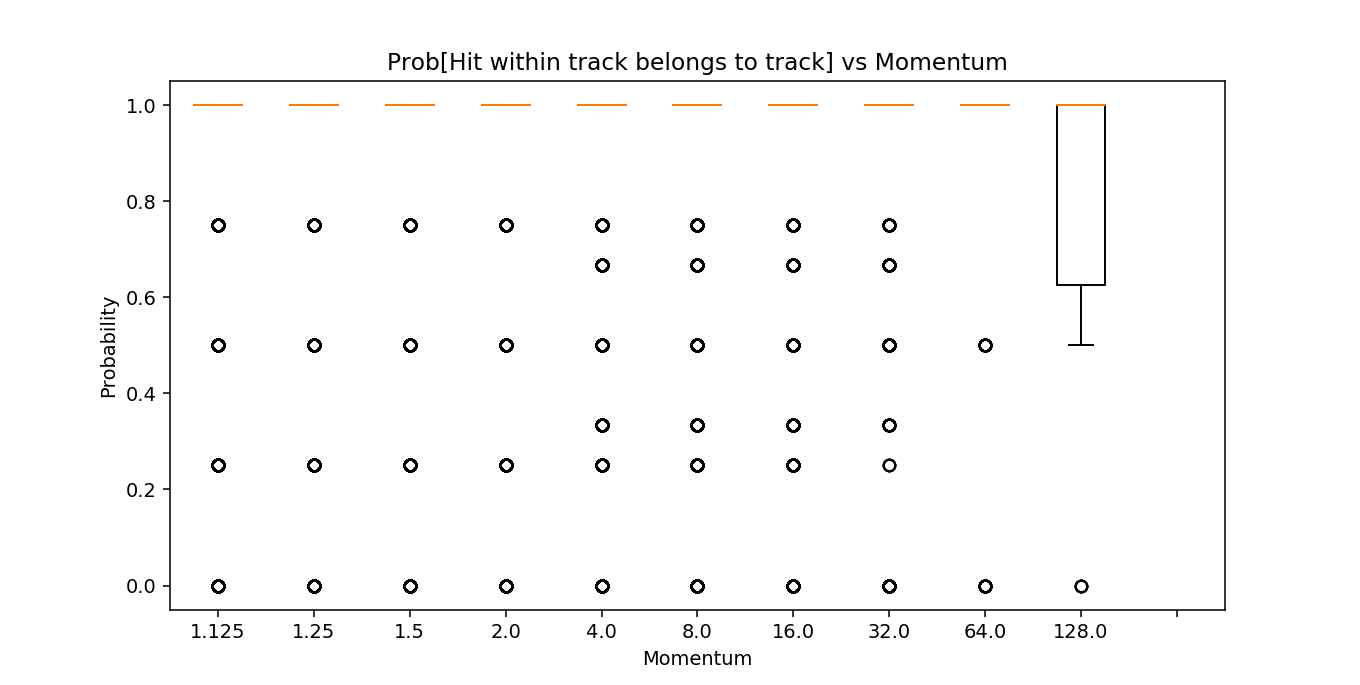

In [137]:
%matplotlib notebook
visuals.boxplot(
    data   = momentum_acc.tolist(),
    fliers = True,
    ylabel = "Probability",
    xlabel = "Momentum",
    title  = "Prob[Hit within track belongs to track] vs Momentum",
    xticks = momentums
)

<IPython.core.display.Javascript object>


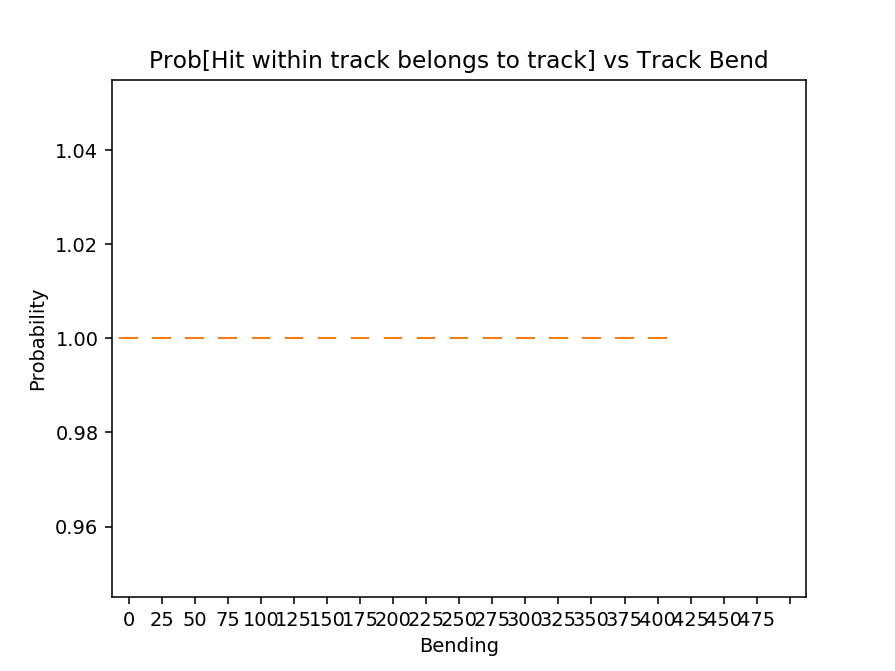

CPU times: user 19min 52s, sys: 440 ms, total: 19min 52s
Wall time: 19min 52s


In [60]:
%%time
bend_amounts = [i for i in range(0, 500, 25)]
bends, acc = metrics.accuracy_vs_bend(test, guesses, order, bend_amounts)
visuals.boxplot(
    data   = acc.tolist(),
    fliers = False,
    ylabel = "Probability",
    xlabel = "Bending",
    title  = "Prob[Hit within track belongs to track] vs Track Bend",
    xticks = bends
)

In [56]:
print(len(test))

19923


In [74]:
%%time
boxes = [[] for _ in range(30)]
for i, event in enumerate(test):
    crossings    = metrics.number_of_crossings(event)
    hits_correct = metrics.percent_of_hits_assigned_correctly(event, guesses[i], order) 
    boxes[crossings].append(hits_correct)
visuals.boxplot(
    data   = boxes,
    fliers =False,
    ylabel = "Probability",
    xlabel = "Crosses",
    title  = "Prob[Hit belongs to right track in event] vs Number of Crossings",
    xticks = [i for i in range(len(boxes))]
)

KeyboardInterrupt: 